# Resolução Desafio Pleno Senior


**DESAFIO: AVALIAÇÃO DE CLIENTES DE UM BANCO**

O Cenário

A avaliação do risco de inadimplência tem um papel importante para os bancos e outros órgãos por estar associada a possíveis perdas e gerar grande impacto nas atividades do mercado financeiro. Fazer uma avaliação certeira permite que empréstimos sejam concedidos a mais pessoas e minimiza a perda da instituição que concede o crédito contribuindo para uma movimentação na economia. 

O Problema

Diante desse cenário precisamos analisar uma base de dados de tomadores de crédito de um banco brasileiro e avaliá-la com o propósito de sua posteriormente utilização para a construção e estimação de um modelo analítico de previsão de inadimplência. No caso, um modelo preditivo que prevê se o tomador será um bom pagador baseado em características de clientes passados contidas nesta base de dados.

A Base

Em anexo, encontra-se a base de dados em questão, bem como um arquivo contendo a descrição das variáveis. É um conjunto de dados grande e acredita-se que este possui diversas informações potencialmente úteis para o aprendizado do modelo em questão.


A Tarefa

Execute a sequência de atividades abaixo e exponha seus resultados em uma apresentação clara e objetiva, incluindo todo comentário que achar relevante.

- 1)	Realize uma análise detalhada das variáveis da base de dados, relações entre as variáveis, possíveis inconsistências e como elas poderiam ser tratados ou eliminados.
- 2)	Treine um modelo de classificação eficiente e robusto para a previsão de bons e maus pagadores. Para isso você deve realizar um experimento utilizando pelo menos dois modelos. Cada um dos modelos deve ter seus parâmetros ajustados com objetivo de maximizar sua capacidade de generalização, além de garantir eficiência e robustez.
- 3)	Utilize todas as métricas que achar necessário para análise dos resultados. 
- 4)	Crie uma apresentação com sua abordagem para resolver o problema e apresentar seus resultados.
- 5)	Inclua qualquer outra informação/análise que achar importante.


Modelagem DS Pleno

O candidato pode usar técnicas como:

- Regressão Logística, Análise Discriminante

- Árvore de Decisão, Support Vector Machine, Naive Bayes

- Métodos Ensemble como: Random Forest, Bagging, Boosting, Adaboost

E comparar os resultados das 2 modelagens escolhidas.

Para comparar os resultados pode ser feita uma matriz de confusão e os calculos de acurácia, precisão (especificidade e especificidade),  recall e/ou  f1-score.

#### Importando bibliotecas

In [70]:
%load_ext autoreload

%autoreload 2

import pandas as pd
import numpy as np

import re # regular expressions
import pandas_profiling # kinda like R DataExplorer

from collections import defaultdict

import qgrid

# libraries for visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns 

# file with path variables 
from config import *

# file with custom function
#from custom_functions import CustomFunctions

# adjusting pandas setting for complete visualization of data
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999


from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Função para criar a matriz de confusão, com o PAGO = 1, no quadrante superior esquerdo

def get_confusion_matrix(reais, preditos, labels):
    """
    Uma função que retorna a matriz de confusão para uma classificação binária
    
    Args:
        reais (list): lista de valores reais
        preditos (list): lista de valores preditos pelo modelos
        labels (list): lista de labels a serem avaliados.
            É importante que ela esteja presente, pois usaremos ela para entender
            quem é a classe positiva e quem é a classe negativa
    
    Returns:
        Um numpy.array, no formato:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    # não implementado
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])


In [35]:
def plot_confusion_matrix(y_true, y_pred, classes,
                         normalize=False,
                         title=None,
                         cmap=plt.cm.Blues):
   """
   This function prints and plots the confusion matrix.
   Normalization can be applied by setting normalize=True.
   """
   if not title:
       if normalize:
           title = 'Normalized confusion matrix'
       else:
           title = 'Confusion matrix, without normalization'
   # Compute confusion matrix
   cm = confusion_matrix(y_true, y_pred)
   # Only use the labels that appear in the data
   classes = classes[unique_labels(y_true, y_pred)]
   if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
   else:
       print('Confusion matrix, without normalization')
   print(cm)
   fig, ax = plt.subplots()
   im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
   ax.figure.colorbar(im, ax=ax)
   # We want to show all ticks...
   ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')
   # Rotate the tick labels and set their alignment.
   plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
   # Loop over data dimensions and create text annotations.
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i in range(cm.shape[0]):
       for j in range(cm.shape[1]):
           ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
   fig.tight_layout()
   return ax

#### Lendo bases

In [4]:
df = pd.read_csv('C:/Users/Elogroup/Documents/Projetos/Processo seletivo/Dados/df_emprestimos_banco.csv', encoding="UTF-8")
df.shape

(50390, 23)

## Verificando a Base de Dados

In [5]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,Conta Conjunta,Valor Conta Corrente,Valor Conta Poupanca,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
0,NaN,NaN,S,2,36,S,N,NaN,NaN,N,N,NaN,NaN,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,57
1,1.0,1894.5078,N,2,39,S,N,2.0,1.0,S,N,NaN,NaN,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,59
2,1.0,NaN,S,2,26,S,N,NaN,1.0,S,N,NaN,NaN,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,56
3,NaN,NaN,N,8,23,N,N,NaN,NaN,N,N,NaN,NaN,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,56
4,NaN,NaN,S,2,33,S,N,NaN,NaN,N,N,NaN,NaN,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,59


In [6]:
df.tail()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,Conta Conjunta,Valor Conta Corrente,Valor Conta Poupanca,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
50385,NaN,NaN,N,4,26,S,N,2.0,NaN,N,N,NaN,NaN,1593.0,36020.75,14170.56,51784.31,0,1,1.686687e+10,0,2020-01-01,57
50386,NaN,NaN,N,4,26,S,N,2.0,NaN,N,N,NaN,NaN,1593.0,1214.50,154.24,2961.74,0,1,1.695679e+10,0,2020-01-01,57
50387,NaN,NaN,S,2,26,S,N,NaN,NaN,S,N,NaN,NaN,1593.0,194.32,26.86,1814.18,0,1,1.448218e+06,0,2020-01-01,57
50388,1.0,1149.8448,N,2,26,S,N,2.0,2.0,N,N,NaN,NaN,1593.0,1038.40,30.53,2661.93,0,1,1.510609e+06,0,2020-01-01,56
50389,1.0,1149.8448,N,2,26,S,N,2.0,2.0,N,N,NaN,NaN,1593.0,467.28,13.74,2074.02,0,1,1.510612e+06,0,2020-01-01,59


- Quantidade de observações nulas em cada variável

In [7]:
# Na em cada coluna
df.isnull().sum()

Escolaridade                   35775
Renda Mensal Informal          40622
Dependentes                        0
Estado Civil                       0
Idade                              0
Conta Poupanca                     0
Conta Salario                      0
Quant Adiantamento Deposito    28547
Qtd Fonte Renda                37584
Cheque Sem Fundo                   0
Conta Conjunta                     0
Valor Conta Corrente           50390
Valor Conta Poupanca           50390
Valor Emprestimo                   0
Multa                              0
Juros                              0
Valor Emprestimo Atualizado        0
PAGO                               0
Controle                           0
ID                                 0
Genero                             0
Data                               0
Estado                             0
dtype: int64

# 1)	Realize uma análise detalhada das variáveis da base de dados, relações entre as variáveis, possíveis inconsistências e como elas poderiam ser tratados ou eliminados.

**Inconsistências na base para verficar se o candidato identificou:**

- Existe uma observação com "Estado Civil" = 5, código que não consta na descrição das variáveis. 
- Existem IDs duplicados, apresentando informações divergentes.
- Duas variáveis só com missing: 'Valor Conta Corrente	Valor' e 'Conta Poupanca'
- 'Escolaridade', 'Renda Mensal Informal', 'Quant Adiantamento Deposito' e 'Qtd Fonte Renda' possuem mais de 50 % de missing
- Os tomadores de crédito que já emitiram cheque sem fundo são melhores pagadores do que os que nunca emitiram.


- 4606 IDs duplicados, melhor exclui-los pois apresentam informações contraditórias.
Ou assumir que o ID que está errado e são pessoas diferentes.

- As variáveis relacionadas ao valor de emprestimo Valor Emprestimo (Valor Emprestimo,	Multa,	Juros,	Valor Emprestimo Atualizado) possuem outlier, possível notar pelos boxplots.
É possivel também realizar uma transformação log para anular os efeitos dessses valores.


Como são dados de emprestimos, é possível haver números discrepantes, porém deve se avaliar se faz sentido considerar valores muito extremos, como os maiores que 50 milhões. 
Esses valores poderiam ser desconsiderados na modelagem para evitar afetar o resultado final.



- Missing data

Todas as variáveis que possuem missing data, possuem mais de 50%, não sendo recomendado realizar extrapolações 

- Escolaridade                    70.99%
- Renda Mensal Informal           80.61%
- Quant Adiantamento Deposito     56.65%
- Qtd Fonte Renda                 74.58%
- Valor Conta Corrente           100.00%
- Valor Conta Poupanca           100.00%


Se a porcentagem de missings por variável fosse menor, seria aconselhado atribuir os valores faltantes por alguma estratégia de imputação. Como calcular a média por categoria de variável por pago e não pago e não e atribuir aos missing datas.

Variáveis com valores constantes:
- Controle: "1"
- Data: "2020-01-01"
- Valor_Conta_Corrente: "nan"
- Valor_Conta_Poupanca: "nan"

Variáveis altamente correlacionadas:
- Valor_Emprestimo e Multa (ρ = 0.9363298488)
- Valor_Emprestimo_Atualizado e Valor_Emprestimo (ρ = 0.9611370408)
- Multa e Juros (ρ = 0.9831362898)	

Variáveis possívelmente importantes para predição: Valor Emprestimo, Estado Civil, Cheque Sem Fundo, Idade, Dependentes

72% dos tomadores de crédito que nunca emitiram Cheque Sem Fundo pagaram a dívida, enquanto que dos que emitiram Cheque Sem Fundo, 89% pagaram. Resultado contrário ao esperado.

76% dos tomadores de crédito que não possuem Conta Conjunta pagaram a dívida, enquanto que dos que possuem Conta Conjunta, 85% pagaram.

76% dos tomadores de crédito que não possuem Conta Salario pagaram a dívida, enquanto que dos que possuem Conta Salario, 70% pagaram.

72% dos tomadores de crédito que não possuem Conta Poupanca pagaram a dívida, enquanto que dos que possuem Conta Poupanca, 77% pagaram.

12 Variáveis Categoricas:
Escolaridade, Dependentes, Estado Civil, Conta Poupanca, Conta Salario, Cheque Sem Fundo, Conta Conjunta, PAGO, Controle, ID, Genero, Estado

10 Variáveis Numéricas: Idade, Renda Mensal Informal, Quant Adiantamento Deposito, Qtd Fonte Renda, Valor Conta Corrente, Valor Conta Poupanca, Valor Emprestimo, Multa, Juros, Valor Emprestimo Atualizado

1 Variável de Data: Data

Nenhuma das variáveis numéricas segue distribuição normal


As variáveis categoricas devem ser transformadas em dummy para serem consideradas no modelo

- Valor Emprestimo, Multa, Juros e Valor Emprestimo Atualizado são altamente correlacionados.
- Renda Mensal Informal também está correlacionado positivamente a Escolaridade.

## Preparando as variáveis para a modelagem

Tansformando as variáveis Categoricas em Dummies

In [8]:
df['Conta Poupanca'] = [1 if (x == 'S')
                        else -1 for x  in df['Conta Poupanca']]

df['Conta Salario'] = [1 if (x == 'S')
                       else -1 for x  in df['Conta Salario']]

df['Cheque Sem Fundo'] = [1 if (x == 'S')
                          else -1 for x  in df['Cheque Sem Fundo']]

df['Conta Conjunta'] = [1 if (x == 'S')
                        else -1 for x  in df['Conta Conjunta']]

df['Dependentes'] = [1 if (x == 'S')
                        else -1 for x  in df['Dependentes']]

In [9]:
df = pd.get_dummies(df, columns=['Estado Civil','Estado'])

In [10]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,Conta Conjunta,Valor Conta Corrente,Valor Conta Poupanca,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado Civil_1,Estado Civil_2,Estado Civil_3,Estado Civil_4,Estado Civil_5,Estado Civil_7,Estado Civil_8,Estado Civil_9,Estado Civil_11,Estado_56,Estado_57,Estado_58,Estado_59
0,NaN,NaN,1,36,1,-1,NaN,NaN,-1,-1,NaN,NaN,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,0,1,0,0,0,0,0,0,0,0,1,0,0
1,1.0,1894.5078,-1,39,1,-1,2.0,1.0,1,-1,NaN,NaN,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1.0,NaN,1,26,1,-1,NaN,1.0,1,-1,NaN,NaN,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,0,1,0,0,0,0,0,0,0,1,0,0,0
3,NaN,NaN,-1,23,-1,-1,NaN,NaN,-1,-1,NaN,NaN,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,0,0,0,0,0,0,1,0,0,1,0,0,0
4,NaN,NaN,1,33,1,-1,NaN,NaN,-1,-1,NaN,NaN,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,0,1,0,0,0,0,0,0,0,0,0,0,1


In [11]:
#df.drop(['Controle', 'ID', 'Data', 'Estado', 'Escolaridade', 'Estado Civil'], inplace=True, axis=1)
#df.shape

In [12]:
#feature_list = list(['Dependentes','Idade', 'Conta Poupanca', 'Conta Salario', 'Cheque Sem Fundo', 
#                     'Conta Conjunta','Valor Emprestimo','Genero'])

feature_list = list(['Dependentes','Idade', 'Conta Poupanca', 'Conta Salario', 'Cheque Sem Fundo', 
                     'Conta Conjunta','Valor Emprestimo','Genero', 'Estado Civil_1', 'Estado Civil_2',
                     'Estado Civil_3', 'Estado Civil_4', 'Estado Civil_5', 'Estado Civil_7', 'Estado Civil_8', 
                     'Estado Civil_9','Estado Civil_11', 'Estado_56', 
                     'Estado_57', 'Estado_58', 'Estado_59'])


# 'Multa', 'Juros', 'Valor Emprestimo Atualizado', 

As variáveis 'Valor Conta Corrente' e 'Valor Conta Poupanca' possuem todas as observações nulas.           

# 2) Treine um modelo de classificação eficiente e robusto para a previsão de bons e maus pagadores. Para isso você deve realizar um experimento utilizando pelo menos dois modelos. Cada um dos modelos deve ter seus parâmetros ajustados com objetivo de maximizar sua capacidade de generalização, além de garantir eficiência e robustez.  

## Separando em 3 bases

In [18]:
train, test = train_test_split(df,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

train, gold_standard = train_test_split(train,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

In [19]:
train.shape

(24691, 34)

In [20]:
test.shape

(15117, 34)

In [21]:
gold_standard.shape

(10582, 34)

In [22]:
x_train = train[feature_list]
y_train = train['PAGO']

x_test = test[feature_list]
y_test = test['PAGO']

x_gold = gold_standard[feature_list]
y_gold = gold_standard['PAGO']

## 1 - Random Forest

In [23]:
clf=RandomForestClassifier(
    n_estimators= 1000, 
    #random_state = random.randint(0,500), 
    random_state = 234, 
    max_depth=10)

In [24]:
clf.fit(x_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=234,
                       verbose=0, warm_start=False)

In [25]:
y_pred_test = clf.predict(x_test)

In [26]:
y_pred_train = clf.predict(x_train)

In [27]:
y_pred_gold = clf.predict(x_gold)

# 3) Utilize todas as métricas que achar necessário para análise dos resultados.

In [36]:
print("Train:", classification_report(y_train, y_pred_train))

print("Test:", classification_report(y_test, y_pred_test))

print("Gold_standard:", classification_report(y_gold, y_pred_gold))

Train:               precision    recall  f1-score   support

           0       0.82      0.22      0.34      5220
           1       0.82      0.99      0.90     19471

    accuracy                           0.82     24691
   macro avg       0.82      0.60      0.62     24691
weighted avg       0.82      0.82      0.78     24691

Test:               precision    recall  f1-score   support

           0       0.73      0.18      0.29      3124
           1       0.82      0.98      0.89     11993

    accuracy                           0.82     15117
   macro avg       0.77      0.58      0.59     15117
weighted avg       0.80      0.82      0.77     15117

Gold_standard:               precision    recall  f1-score   support

           0       0.76      0.19      0.30      2193
           1       0.82      0.98      0.90      8389

    accuracy                           0.82     10582
   macro avg       0.79      0.59      0.60     10582
weighted avg       0.81      0.82      0.77   

In [37]:
# Importancia das features 
importances = list(clf.feature_importances_)
# Listar nome da variavel e sua importancia
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Ordenar a importancia
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Mostrar os resultados
[print('Variavel: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

Variavel: Valor Emprestimo     Importancia: 0.33
Variavel: Estado Civil_4       Importancia: 0.15
Variavel: Estado Civil_2       Importancia: 0.14
Variavel: Cheque Sem Fundo     Importancia: 0.11
Variavel: Idade                Importancia: 0.1
Variavel: Dependentes          Importancia: 0.06
Variavel: Conta Poupanca       Importancia: 0.02
Variavel: Estado Civil_8       Importancia: 0.02
Variavel: Conta Salario        Importancia: 0.01
Variavel: Conta Conjunta       Importancia: 0.01
Variavel: Genero               Importancia: 0.01
Variavel: Estado Civil_9       Importancia: 0.01
Variavel: Estado_56            Importancia: 0.01
Variavel: Estado_57            Importancia: 0.01
Variavel: Estado_58            Importancia: 0.01
Variavel: Estado_59            Importancia: 0.01
Variavel: Estado Civil_1       Importancia: 0.0
Variavel: Estado Civil_3       Importancia: 0.0
Variavel: Estado Civil_5       Importancia: 0.0
Variavel: Estado Civil_7       Importancia: 0.0
Variavel: Estado Civil_11

Matriz de Confusão VP no quadrante superior esquerdo

In [38]:
cm_train = get_confusion_matrix(y_train, y_pred_train, labels=[1,0])
cm_train

array([[19216,   255],
       [ 4092,  1128]])

In [39]:
cm_test = get_confusion_matrix(y_test, y_pred_test, labels=[1,0])
cm_test

array([[11775,   218],
       [ 2549,   575]])

In [40]:
cm_gold = get_confusion_matrix(y_gold, y_pred_gold, labels=[1,0])
cm_gold

array([[8262,  127],
       [1781,  412]])

Matriz de Confusão VP no quadrante inferior direito

Confusion matrix, without normalization
[[ 1128  4092]
 [  255 19216]]
Confusion matrix, without normalization
[[  575  2549]
 [  218 11775]]
Confusion matrix, without normalization
[[ 412 1781]
 [ 127 8262]]


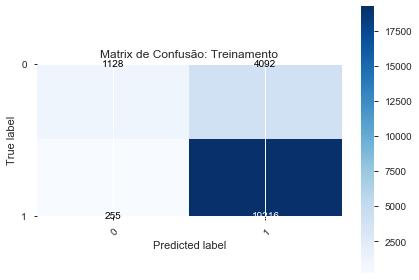

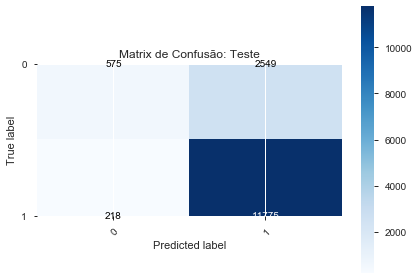

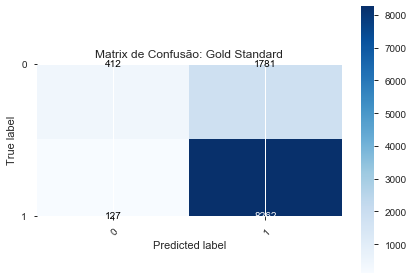

In [41]:
#plot_confusion_matrix(y_gold, y_pred_gold)
plot_1 = plot_confusion_matrix(y_train, y_pred_train, classes=np.array([0,1]),
                      title='Matrix de Confusão: Treinamento')

plot_2 = plot_confusion_matrix(y_test, y_pred_test, classes=np.array([0,1]),
                      title='Matrix de Confusão: Teste')

plot_3 = plot_confusion_matrix(y_gold, y_pred_gold, classes=np.array([0,1]),
                      title='Matrix de Confusão: Gold Standard')

## 2 - Random Forest -  Modelagem com a base balanceada

In [42]:
df_pago = df[df['PAGO']==1]
df_npago = df[df['PAGO']==0]
df['PAGO'].value_counts()

1    39853
0    10537
Name: PAGO, dtype: int64

In [43]:
print(df_pago['PAGO'].value_counts())

print(df_npago['PAGO'].value_counts())


1    39853
Name: PAGO, dtype: int64
0    10537
Name: PAGO, dtype: int64


In [44]:
df_pago=df_pago.sample(n=10537, random_state=234)
df_pago.shape

(10537, 34)

In [45]:
df_balanceado = df_pago.append(df_npago, sort = False)
df_balanceado['PAGO'].value_counts()

1    10537
0    10537
Name: PAGO, dtype: int64

Separando em 3 bases

In [46]:
train_balanceado, test_balanceado = train_test_split(df_balanceado,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

train_balanceado, gold_standard_balanceado = train_test_split(train_balanceado,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

In [47]:
train_balanceado.shape

(10325, 34)

In [48]:
test_balanceado.shape

(6323, 34)

In [49]:
gold_standard_balanceado.shape

(4426, 34)

In [50]:
x_train = train_balanceado[feature_list]
y_train = train_balanceado['PAGO']

x_test = test_balanceado[feature_list]
y_test = test_balanceado['PAGO']

x_gold = gold_standard_balanceado[feature_list]
y_gold = gold_standard_balanceado['PAGO']

In [51]:
clf=RandomForestClassifier(
    n_estimators= 1000, 
    #random_state = random.randint(0,500), 
    random_state = 234, 
    max_depth=10)

In [52]:
clf.fit(x_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=234,
                       verbose=0, warm_start=False)

In [53]:
y_pred_test = clf.predict(x_test)

In [54]:
y_pred_train = clf.predict(x_train)

In [55]:
y_pred_gold = clf.predict(x_gold)

In [56]:
print("Train:", classification_report(y_train, y_pred_train))

print("Test:", classification_report(y_test, y_pred_test))

print("Gold_standard:", classification_report(y_gold, y_pred_gold))

Train:               precision    recall  f1-score   support

           0       0.77      0.74      0.76      5151
           1       0.75      0.79      0.77      5174

    accuracy                           0.76     10325
   macro avg       0.76      0.76      0.76     10325
weighted avg       0.76      0.76      0.76     10325

Test:               precision    recall  f1-score   support

           0       0.72      0.69      0.71      3118
           1       0.71      0.74      0.73      3205

    accuracy                           0.72      6323
   macro avg       0.72      0.72      0.72      6323
weighted avg       0.72      0.72      0.72      6323

Gold_standard:               precision    recall  f1-score   support

           0       0.73      0.68      0.70      2268
           1       0.68      0.73      0.71      2158

    accuracy                           0.71      4426
   macro avg       0.71      0.71      0.71      4426
weighted avg       0.71      0.71      0.71   

In [57]:
# Importancia das features 
importances = list(clf.feature_importances_)
# Listar nome da variavel e sua importancia
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Ordenar a importancia
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Mostrar os resultados
[print('Variavel: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

Variavel: Valor Emprestimo     Importancia: 0.28
Variavel: Estado Civil_2       Importancia: 0.17
Variavel: Estado Civil_4       Importancia: 0.14
Variavel: Idade                Importancia: 0.12
Variavel: Cheque Sem Fundo     Importancia: 0.1
Variavel: Dependentes          Importancia: 0.08
Variavel: Conta Poupanca       Importancia: 0.02
Variavel: Genero               Importancia: 0.02
Variavel: Estado Civil_8       Importancia: 0.02
Variavel: Conta Salario        Importancia: 0.01
Variavel: Conta Conjunta       Importancia: 0.01
Variavel: Estado Civil_3       Importancia: 0.01
Variavel: Estado_56            Importancia: 0.01
Variavel: Estado_57            Importancia: 0.01
Variavel: Estado_58            Importancia: 0.01
Variavel: Estado_59            Importancia: 0.01
Variavel: Estado Civil_1       Importancia: 0.0
Variavel: Estado Civil_5       Importancia: 0.0
Variavel: Estado Civil_7       Importancia: 0.0
Variavel: Estado Civil_9       Importancia: 0.0
Variavel: Estado Civil_11

In [46]:
cm_train = get_confusion_matrix(y_train, y_pred_train, labels=[1,0])
cm_train

array([[4065, 1109],
       [1354, 3797]])

In [47]:
cm_test = get_confusion_matrix(y_test, y_pred_test, labels=[1,0])
cm_test

array([[2384,  821],
       [ 954, 2164]])

In [48]:
cm_gold = get_confusion_matrix(y_gold, y_pred_gold, labels=[1,0])
cm_gold

array([[1583,  575],
       [ 730, 1538]])

Confusion matrix, without normalization
[[3797 1354]
 [1109 4065]]
Confusion matrix, without normalization
[[2164  954]
 [ 821 2384]]
Confusion matrix, without normalization
[[1538  730]
 [ 575 1583]]


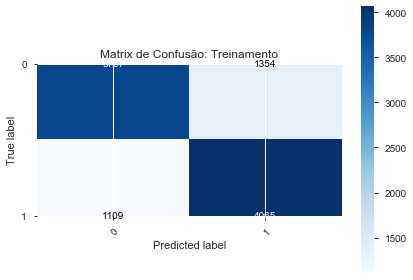

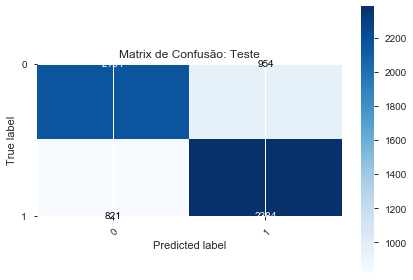

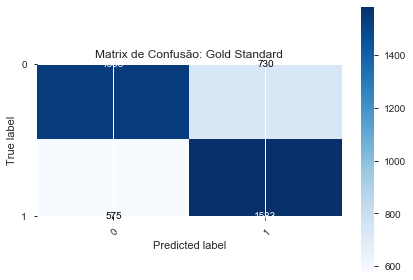

In [49]:
#plot_confusion_matrix(y_gold, y_pred_gold)
plot_1 = plot_confusion_matrix(y_train, y_pred_train, classes=np.array([0,1]),
                      title='Matrix de Confusão: Treinamento')

plot_2 = plot_confusion_matrix(y_test, y_pred_test, classes=np.array([0,1]),
                      title='Matrix de Confusão: Teste')

plot_3 = plot_confusion_matrix(y_gold, y_pred_gold, classes=np.array([0,1]),
                      title='Matrix de Confusão: Gold Standard')

## 3 - Modelagem - Árvore de decisão


In [58]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)


In [59]:
#Predict the response for test dataset
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)
y_pred_gold = clf.predict(x_gold)


In [60]:
print("Train:", classification_report(y_train, y_pred_train))
print("Test:", classification_report(y_test, y_pred_test))
print("Gold:", classification_report(y_gold, y_pred_gold))

Train:               precision    recall  f1-score   support

           0       0.90      0.96      0.93      5151
           1       0.96      0.89      0.92      5174

    accuracy                           0.93     10325
   macro avg       0.93      0.93      0.93     10325
weighted avg       0.93      0.93      0.93     10325

Test:               precision    recall  f1-score   support

           0       0.63      0.67      0.65      3118
           1       0.65      0.61      0.63      3205

    accuracy                           0.64      6323
   macro avg       0.64      0.64      0.64      6323
weighted avg       0.64      0.64      0.64      6323

Gold:               precision    recall  f1-score   support

           0       0.65      0.68      0.66      2268
           1       0.64      0.61      0.63      2158

    accuracy                           0.65      4426
   macro avg       0.65      0.64      0.64      4426
weighted avg       0.65      0.65      0.64      4426



## 4 - Modelagem Regressão Logística

In [62]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
y_pred_test = logreg.predict(x_test)
y_pred_train = logreg.predict(x_train)
y_pred_gold = logreg.predict(x_gold)

In [63]:
print("Acurácia na Base de Treinamento:",metrics.accuracy_score(y_train, y_pred_train).round(3))
print("Acurácia na Base de Teste:",metrics.accuracy_score(y_test, y_pred_test).round(3))

Acurácia na Base de Treinamento: 0.792
Acurácia na Base de Teste: 0.797


In [63]:
print("Train:", classification_report(y_train, y_pred_train))
print("Test:", classification_report(y_test, y_pred_test))
print("Gold:", classification_report(y_gold, y_pred_gold))

Train:               precision    recall  f1-score   support

           0       0.90      0.96      0.93      5151
           1       0.96      0.89      0.92      5174

    accuracy                           0.93     10325
   macro avg       0.93      0.93      0.93     10325
weighted avg       0.93      0.93      0.93     10325

Test:               precision    recall  f1-score   support

           0       0.63      0.67      0.65      3118
           1       0.65      0.61      0.63      3205

    accuracy                           0.64      6323
   macro avg       0.64      0.64      0.64      6323
weighted avg       0.64      0.64      0.64      6323

Gold:               precision    recall  f1-score   support

           0       0.65      0.68      0.66      2268
           1       0.64      0.61      0.63      2158

    accuracy                           0.65      4426
   macro avg       0.65      0.64      0.64      4426
weighted avg       0.65      0.65      0.64      4426



In [64]:
cm_train = get_confusion_matrix(y_train, y_pred_train, labels=[1,0])
cm_train

array([[4619,  555],
       [ 213, 4938]])

In [65]:
cm_test = get_confusion_matrix(y_test, y_pred_test, labels=[1,0])
cm_test

array([[1968, 1237],
       [1043, 2075]])

In [66]:
cm_gold = get_confusion_matrix(y_gold, y_pred_gold, labels=[1,0])
cm_gold

array([[1320,  838],
       [ 732, 1536]])

## 5 - Modelagem - SVM

In [74]:
train, test = train_test_split(df,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

train, gold_standard = train_test_split(train,
                               test_size=0.3,
                               random_state = 42) # 70% treinamento e 30% teste

In [75]:
train.shape

(24691, 34)

In [76]:
test.shape

(15117, 34)

In [77]:
gold_standard.shape

(10582, 34)

In [78]:
x_train = train[feature_list]
y_train = train['PAGO']

x_test = test[feature_list]
y_test = test['PAGO']

x_gold = gold_standard[feature_list]
y_gold = gold_standard['PAGO']

In [79]:
train.shape

(24691, 34)

kernel Linear

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

In [ ]:
y_pred_test = svclassifier.predict(x_test)
y_pred_gold = svclassifier.predict(x_gold)

In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

print(confusion_matrix(y_gold,y_pred_gold))
print(classification_report(y_gold,y_pred_gold))

Kernel Polinomial

In [ ]:
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(x_train, y_train)

In [ ]:
y_pred_test = svclassifier.predict(x_test)
y_pred_gold = svclassifier.predict(x_gold)

In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

print(confusion_matrix(y_gold,y_pred_gold))
print(classification_report(y_gold,y_pred_gold))

Kernel Gaussiano

In [ ]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

In [ ]:
y_pred_test = svclassifier.predict(x_test)
y_pred_gold = svclassifier.predict(x_gold)

In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

print(confusion_matrix(y_gold,y_pred_gold))
print(classification_report(y_gold,y_pred_gold))